In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
def fetch_stock_data(ticker, start_date):
    """
    Fetch stock price data.

    Parameters:
    ticker (str): Stock ticker symbol
    start_date (str): Start date for data retrieval in 'YYYY-MM-DD' format

    Returns:
    stock_data (pandas.DataFrame): Historical price data including 'Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume' columns
    """
    # Set the current date as the end date for the data retrieval
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    
    # Download stock price data using yfinance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    return stock_data


def moving_average_crossover_strategy(data, short_window=50, long_window=200):
    """
    Implement the Moving Average Crossover strategy to generate buy/sell signals, and calculate the profit/loss from each trade.

    Parameters:
    data (pandas.DataFrame): Stock price data
    short_window (int, optional): Period for the short-term moving average
    long_window (int, optional): Period for the long-term moving average

    Returns:
    signals (pandas.DataFrame): Historical prices, moving averages, and buy/sell signals, indexed by date (1.0 = Buy, -1.0 = Sell)
    short_window (int): The short moving average window period
    long_window (int): The long moving average window period
    """
    # Initialize a DataFrame to hold price and calculated moving averages
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['Close']
    
    # Compute short-term and long-term moving averages
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate trading signals: 1.0 = Buy, 0.0 = Hold/Sell
    signals['signal'] = 0.0
    signals.iloc[short_window:, signals.columns.get_loc('signal')] = np.where(
        signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0, 0.0
    )

    # Identify buy/sell positions based on signal changes
    signals['positions'] = signals['signal'].diff()

    # Extract buy and sell signals
    buy_signals = signals.loc[signals['positions'] == 1.0]
    sell_signals = signals.loc[signals['positions'] == -1.0]

    # Calculate revenue and print details of each trade
    paired_signals = min(len(buy_signals), len(sell_signals))
    total_revenue = 0

    for i in range(paired_signals):
        buy_date = buy_signals.index[i]
        sell_date = sell_signals.index[i]
        
        buy_price = buy_signals['price'].iloc[i]
        sell_price = sell_signals['price'].iloc[i]
        
        revenue = sell_price - buy_price
        total_revenue += revenue

        # Display trade details
        print(f"Trade {i + 1}:")
        print(f"  Buy on {buy_date.date()}: Price = {buy_price:.2f}")
        print(f"  Sell on {sell_date.date()}: Price = {sell_price:.2f}")
        print(f"  Revenue from this trade: {revenue:.2f}")
        print("-" * 30)

    # Display total revenue from all trades
    print(f"Total Revenue from all trades: {total_revenue:.2f}")

    return signals, short_window, long_window


def plot_signals(ticker, signals, short_window, long_window):
    """
    Plot the stock's price along with moving averages and buy/sell signals using matplotlib.

    Parameters:
    ticker (str): Stock ticker symbol
    signals (pandas.DataFrame): Historical prices, moving averages, and buy/sell signals, indexed by date
    short_window (int): The short moving average window period
    long_window (int): The long moving average window period

    Returns:
    None
    """
    plt.figure(figsize=(14, 7))

    # Plot the stock's closing price
    plt.plot(signals.index, signals['price'], label='Close Price', color='blue', linewidth=2)

    # Plot short and long moving averages
    plt.plot(signals.index, signals['short_mavg'], label=f'{short_window}-Day Moving Average', color='orange', linewidth=2)
    plt.plot(signals.index, signals['long_mavg'], label=f'{long_window}-Day Moving Average', color='green', linewidth=2)

    # Mark Buy signals with green upward-pointing triangles
    plt.scatter(signals.loc[signals['positions'] == 1.0].index, 
                signals['short_mavg'][signals['positions'] == 1.0], 
                label='Buy Signal', marker='^', color='green', s=100, zorder=5)

    # Mark Sell signals with red downward-pointing triangles
    plt.scatter(signals.loc[signals['positions'] == -1.0].index, 
                signals['short_mavg'][signals['positions'] == -1.0], 
                label='Sell Signal', marker='v', color='red', s=100, zorder=5)

    # Set plot title and labels
    plt.title(f'{ticker} Stock Price with Moving Average Crossover Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')

    # Add legend and grid
    plt.legend()
    plt.grid(True)

    # Rotate date labels and adjust layout
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Display the plot
    plt.show()


def plot_signals_plotly(ticker, signals, short_window, long_window):
    """
    Plot the stock's price with moving averages and buy/sell signals using Plotly for interactive charts.

    Parameters:
    ticker (str): Stock ticker symbol
    signals (pandas.DataFrame): Historical prices, moving averages, and buy/sell signals, indexed by date
    short_window (int): The short moving average window period
    long_window (int): The long moving average window period

    Returns:
    None
    """
    fig = go.Figure()

    # Plot the stock's closing price
    fig.add_trace(go.Scatter(x=signals.index, 
                             y=signals['price'], 
                             mode='lines', 
                             name='Close Price',
                             line=dict(color='blue', width=2),
                             hovertemplate="Price: %{y:.2f}<extra></extra>"))

    # Plot short and long moving averages
    fig.add_trace(go.Scatter(x=signals.index, 
                             y=signals['short_mavg'], 
                             mode='lines', 
                             name=f'{short_window}-Day Moving Average', 
                             line=dict(color='orange', width=2),
                             hovertemplate="Short MA: %{y:.2f}<extra></extra>"))

    fig.add_trace(go.Scatter(x=signals.index, 
                             y=signals['long_mavg'], 
                             mode='lines', 
                             name=f'{long_window}-Day Moving Average',
                             line=dict(color='green', width=2),
                             hovertemplate="Long MA: %{y:.2f}<extra></extra>"))

    # Mark Buy signals with green triangles
    fig.add_trace(go.Scatter(x=signals.loc[signals['positions'] == 1.0].index, 
                             y=signals['short_mavg'][signals['positions'] == 1.0], 
                             mode='markers', 
                             marker=dict(symbol='triangle-up', size=10, color='green'),
                             name='Buy Signal',
                             hovertemplate="Buy Signal<extra></extra>"))

    # Mark Sell signals with red triangles
    fig.add_trace(go.Scatter(x=signals.loc[signals['positions'] == -1.0].index, 
                             y=signals['short_mavg'][signals['positions'] == -1.0], 
                             mode='markers', 
                             marker=dict(symbol='triangle-down', size=10, color='red'),
                             name='Sell Signal',
                             hovertemplate="Sell Signal<extra></extra>"))

    # Configure plot layout
    fig.update_layout(
        title=f'{ticker} Stock Price with Moving Average Crossover Signals',
        xaxis_title='Date',
        yaxis_title='Price',
        legend=dict(x=0, y=1, bgcolor='rgba(255,255,255,0)', bordercolor='rgba(255,255,255,0)'),
        hovermode='x',
        template='plotly_white',
        height=600,
        xaxis_rangeslider_visible=True
    )

    # Display the interactive plot
    fig.show()

[*********************100%%**********************]  1 of 1 completed


Trade 1:
  Buy on 2018-03-15: Price = 21.71
  Sell on 2018-03-29: Price = 17.74
  Revenue from this trade: -3.96
------------------------------
Trade 2:
  Buy on 2018-07-30: Price = 19.34
  Sell on 2018-09-11: Price = 18.63
  Revenue from this trade: -0.72
------------------------------
Trade 3:
  Buy on 2018-12-03: Price = 23.90
  Sell on 2019-02-28: Price = 21.33
  Revenue from this trade: -2.57
------------------------------
Trade 4:
  Buy on 2019-11-05: Price = 21.15
  Sell on 2021-07-09: Price = 218.98
  Revenue from this trade: 197.84
------------------------------
Trade 5:
  Buy on 2021-08-30: Price = 243.64
  Sell on 2022-05-26: Price = 235.91
  Revenue from this trade: -7.73
------------------------------
Trade 6:
  Buy on 2023-06-23: Price = 256.60
  Sell on 2024-02-01: Price = 188.86
  Revenue from this trade: -67.74
------------------------------
Total Revenue from all trades: 115.11


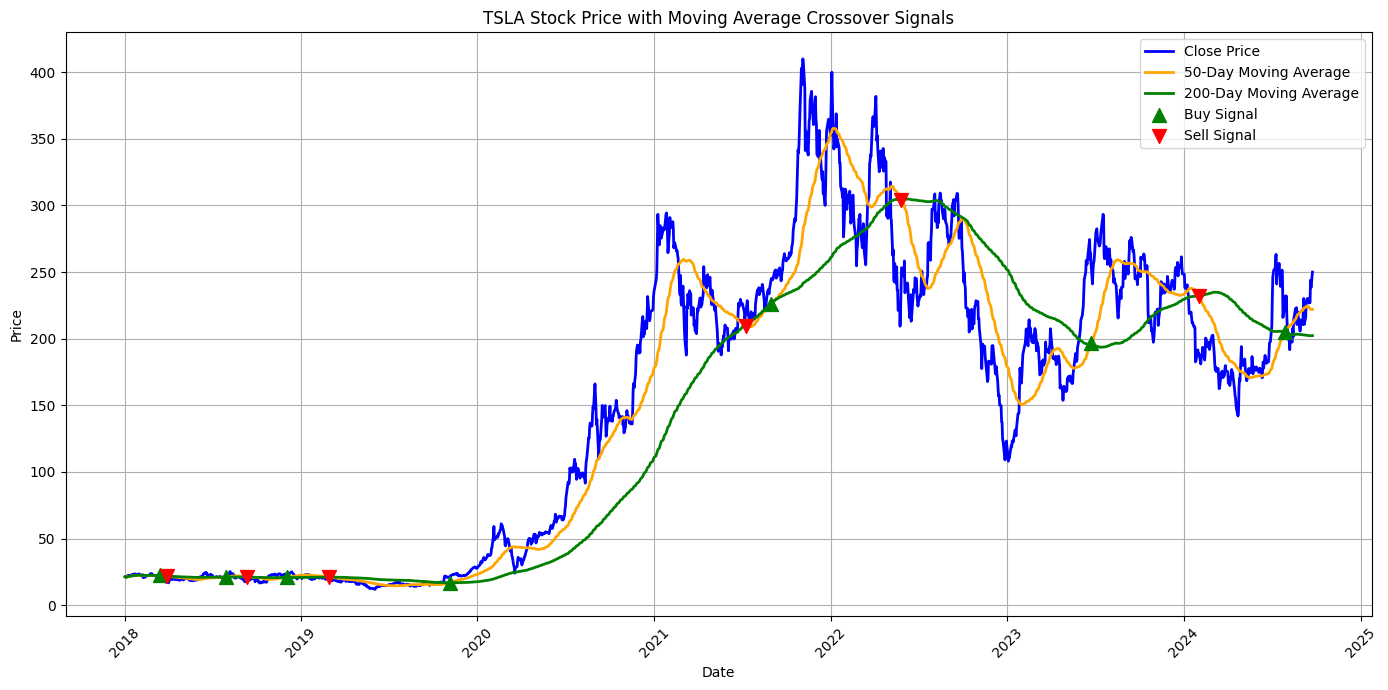

In [3]:
# Example usage
ticker = "TSLA" 
start_date = "2018-01-01" 

# Fetch the stock data
stock_data = fetch_stock_data(ticker, start_date)

# Run the moving average crossover strategy
signals, short_window, long_window = moving_average_crossover_strategy(stock_data)

# Plot the signals
plot_signals(ticker, signals, short_window, long_window)
plot_signals_plotly(ticker, signals, short_window, long_window)